<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D0%B8%D0%B7%D0%B8%D1%82%D0%BD%D1%8B%D1%85_%D0%BA%D0%B0%D1%80%D1%82%D0%BE%D1%87%D0%B5%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание визитных карточек 

# Business card recognition 


В этом уроке мы будем использовать очень похожий рабочий процесс, как в пердыдущем, но только на визитных карточках. Так же научимся работать с регулярными выражениями.

In this lesson, we will use a very similar workflow to the first one, but on business cards. We'll also learn how to work with regular expressions.

In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_13.OCR_card.zip
!unzip -qq Lesson_13.OCR_card.zip
%cd OCR_card

--2022-02-10 07:32:07--  http://dataudt.ru/datasets/cv/Lesson_13.OCR_card.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14417438 (14M) [application/zip]
Saving to: ‘Lesson_13.OCR_card.zip’

Lesson_13.OCR_card. 100%[===================>]  13.75M  4.38MB/s    in 3.1s    

2022-02-10 07:32:11 (4.38 MB/s) - ‘Lesson_13.OCR_card.zip’ saved [14417438/14417438]

/content/OCR_card


Настроим работу tesseract 

Let's set up a tesseract 


In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [4]:
!mv "/content/OCR_card/rus.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata/"

In [5]:
# импортируем необходимые пакеты
# import the necessary packages
from imutils.perspective import four_point_transform
from google.colab.patches import cv2_imshow
import pytesseract
import imutils
import cv2
import re

Тогда у нас есть --min-conf, который является минимальной достоверностью (по шкале 0-100), необходимой для успешного обнаружения текста. Вы можете увеличить --min-conf, чтобы отсечь слабые текстовые обнаружения.


Then we have --min-conf, which is the minimum confidence (on a scale of 0-100) needed for successful text detection. You can increase the --min-conf to cut off weak text detections.

In [6]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "image" : "/content/OCR_card/ex1.jpg", # путь к входному изображению, которое мы будем распознавать
                                         # the path to the input image we are going to recognize
  "debug": 1, # визуализируем ли мы каждый шаг конвейера  (при -1 не будем)
                # whether we visualize each step of the conveyor (at -1 we will not)
  "min-conf":0, # является минимальной достоверностью (по шкале 0-100), необходимой для успешного обнаружения текста
                # is the minimum confidence (on a scale of 0-100) required for successful text detection
}

In [7]:
# загружаем входное изображение, изменяем его размер и вычисляем 
# отношение *новой* ширины к *старой* ширине
# load the input image from disk, resize it, and compute the ratio
# of the *new* width to the *old* width
orig = cv2.imread(args["image"])
image = orig.copy()
image = imutils.resize(image, width=600)
ratio = orig.shape[1] / float(image.shape[1])


# преобразуем изображение в градации серого, 
# слегка размываем его, а затем применяем определение краев, 
# чтобы выявить контур визитной карточки
# convert the image to grayscale, blur it, and apply edge detection
# to reveal the outline of the business card
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)

# находим контуры на карте граней, сортируем их по размеру (в порядке убывания) 
# и захватываем самые крупные контуры
# detect contours in the edge map, sort them by size (in descending
# order), and grab the largest contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

# инициализируем контур, который соответствует контуру визитной карточки
# initialize a contour that corresponds to the business card outline
cardCnt = None

Business Card Outline


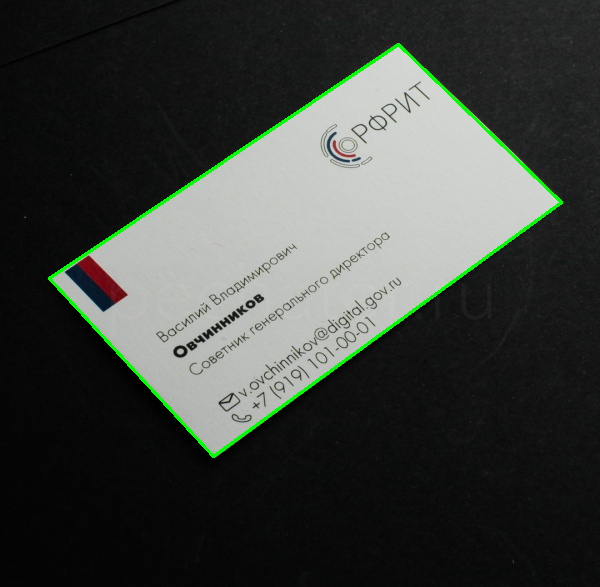

Business Card Transform


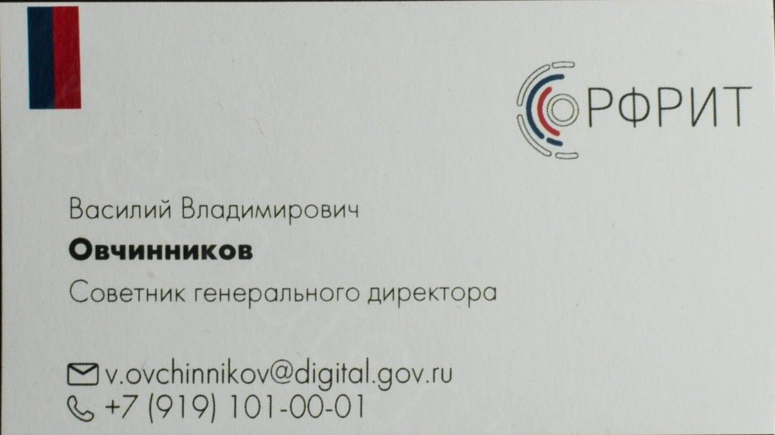

PHONE NUMBERS
+7 (919) 101-00-01


EMAILS
v.ovchinnikov@digital.gov.ru


NAME/JOB TITLE
1 и

Василий Владимирович
Овчинников
Советник генерального директора


In [8]:
# проходимся по контурам
# loop over the contours
for c in cnts:
    # аппроксимируем контур
    # approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если наш аппроксимированный контур имеет четыре 
    # точки, то можно считать, что мы нашли визитную карточку
    # if this is the first contour we've encountered that has four
	# vertices, then we can assume we've found the business card
	if len(approx) == 4:
		cardCnt = approx
		break

# если контур пуст, то скрипт выдает ошибку
# if the business card contour is empty then our script could not
# find the  outline of the card, so raise an error
if cardCnt is None:
	raise Exception(("Could not find receipt outline. "
		"Try debugging your edge detection and contour steps."))

# если включена отладка, то рисуем контур визитной карточки на изображении
# check to see if we should draw the contour of the business card
# on the image and then display it to our screen
if args["debug"] > 0:
    output = image.copy()
    cv2.drawContours(output, [cardCnt], -1, (0, 255, 0), 2)
    print("Business Card Outline")
    cv2_imshow(output)

# применяем преобразование перспективы в четырех точках к первоначальному изображению
# apply a four point perspective transform to the *original* image to
# obtain a top-down birds eye view of the business card
card = four_point_transform(orig, cardCnt.reshape(4, 2) * ratio)

# выводим трансформированное изображение
# show transformed image
print("Business Card Transform")
cv2_imshow(card)

# преобразуем визитную карточку из BGR в RGB канал, а затем применим OCR
# convert the business card from BGR to RGB channel ordering and then
# OCR it
rgb = cv2.cvtColor(card, cv2.COLOR_BGR2RGB)
text = pytesseract.image_to_string(rgb, lang='rus+eng')

# мы будем использовать регулярные выражения, чтобы достать номера телефонов 
# и адреса электронной почты из визитной карточки
# use regular expressions to parse out phone numbers and email
# addresses from the business card
phoneNums = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', text)
emails = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", text)

# так же попробуем извлечь имена при помощи тех же регулярных выражений 
# (но тут уже сложнее и не факт, что выйдет)
# attempt to use regular expressions to parse out names/titles (not
# necessarily reliable)
nameExp = r"^[\w'\-,.][^0-9_!¡?÷?¿/\\+=@#$%ˆ&*(){}|~<>;:[\]]{2,}"
names = re.findall(nameExp, text)

# показываем заголовок с номерами телефонов
# show the phone numbers header
print("PHONE NUMBERS")
print("=============")

# перебираем обнаруженные телефонные номера и выводим их 
# loop over the detected phone numbers and print them to our terminal
for num in phoneNums:
	print(num.strip())

# показать заголовок адреса электронной почты
# show the email addresses header
print("\n")
print("EMAILS")
print("======")

# перебираем обнаруженные адреса электронной почты и выводим их
# loop over the detected email addresses and print them to our
# terminal
for email in emails:
	print(email.strip())

# покажем заголовок имени / должности
# show the name/job title header
print("\n")
print("NAME/JOB TITLE")
print("==============")

# перебираем обнаруженные имена или названия и выводим их
# loop over the detected name/job titles and print them to our
# terminal
for name in names:
	print(name.strip())
 